In [14]:
!git clone https://github.com/crispitagorico/Hall-areas.git
!pip install iisignature

Cloning into 'Hall-areas'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 68 (delta 28), reused 47 (delta 12), pack-reused 0
Unpacking objects: 100% (68/68), 840.82 KiB | 3.05 MiB/s, done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
%cd Hall-areas/

/content/Hall-areas/Hall-areas


In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import sympy as sym
from itertools import product
from tqdm.notebook import trange

from free_lie_algebra import *
import iisignature

## Mathematical derivation

Suppose that $X$ is $1$-dimensional and let $\hat X_t = (t,X_t) \in \mathbb{R}^2$ and assume for simplicity that $X_0 = 0$. Let $n \in \mathbb{N}$ be a truncation hyperparameter. 

We are interested in the following optimisation

$$\min_{\ell \in T^n((\mathbb{R}^2)^*)}\mathbb{E}\left[\left(f(\hat X_{0,T}) - p_0 - \int_0^T(\ell,S(\hat X)_{0,t})dX_t\right)^2\right] \quad \text{where} \quad \ell = \sum_{|w| \leq n} \alpha_w w$$

In what follows $\{\mathbf 1, \mathbf 2\}$ are letters.


Let $n_0 \in \mathbb{N}$. We approximate (offline) the payoff $f$ by a signature payoff, i.e. we find $\ell_0 \in T^{n_0}((\mathbb{R}^2)^*)$ such that

$$f(\hat X_{0,T}) \approx \left(\ell_0, S(\hat X)_{0,T}\right) \quad \text{where} \quad \ell_0 = \sum_{|w| \leq n_0} \beta_w w$$

Let $* : T((\mathbb{R}^2))^* \times T((\mathbb{R}^2))^* \to T((\mathbb{R}^2))^*$ be the shuffle product. 

Define the half-shuffle product $\prec : T((\mathbb{R}^2))^* \times T((\mathbb{R}^2))^* \to T((\mathbb{R}^2))^*$ as follows (it suffices to define it on basis elements, i.e. words): 

for two words $v$ and $w=w_1...w_n$

$$v \prec w = (v * w_1...w_{n-1})w_n$$

Then, the P&L can be rewritten as follows

$$\int_0^T(\ell,S(\hat X)_{0,t})dX_t = \left((\ell \prec \mathbf{2}), S(\hat X)_{0,T}\right)$$

The full optimisation can be rewritten as follows

\begin{align}
    \min_{\ell \in T^n((\mathbb{R}^2)^*)}\mathbb{E}\left[\left((\ell_0, S(\hat X)_{0,T}) - (\textbf 0, S(\hat X)_{0,T}) p_0 - \left((\ell \prec \mathbf{2}), S(\hat X)_{0,T}\right)\right)^2\right] 
    &= \min_{\ell \in T^n((\mathbb{R}^2))^*}\mathbb{E}\left[\left((\ell_0 - p_0 \textbf 0 - (\ell \prec \mathbf{2}), S(\hat X)_{0,T})\right)^2\right] \\
    &= \min_{\ell \in T^n((\mathbb{R}^2))^*}\mathbb{E}\left[(\ell_0 - p_0 \textbf 0 - (\ell \prec \mathbf{2})) * (\ell_0 - p_0 \textbf 0 - (\ell \prec \mathbf{2})) , S(\hat X)_{0,T}) \right] \\
    &= \min_{\ell \in T^n((\mathbb{R}^2))^*}\left(\ell_0 - p_0 \textbf 0 - (\ell \prec \mathbf{2})) * (\ell_0 - p_0 \textbf 0 - (\ell \prec \mathbf{2}) , \mathbb{E}\left[S(\hat X)_{0,T}) \right] \right)
\end{align}

In [32]:
# utility
def make_linear_functional(coeffs, n_):
    linear_functional = 0.*word2Elt('')
    for i, w in enumerate(wordIter(2, n_)):
        linear_functional += coeffs[i]*word2Elt(w)
    return linear_functional

### Price paths sampler

In [33]:
def gBM(N, T=1, length=100, X0=1., mu=0.01, sigma=0.2):
    """ Time-augmented geometric BM sampler
    
    - Inputs:
        - N (int)       : number of sample paths
        - T (float)     : maturity
        - length (int)  : number of time steps
        - X0 (float)    : initial stock price
        - mu (float)    : drift
        - sigma (float) : volatility
   
    - Output:
        - X: np array of shape (N, n, 2)
    """
    
    dt = T/length
    X = np.exp((mu - sigma ** 2 / 2) * dt + sigma * np.random.normal(0, np.sqrt(dt), size=(N, length-1)).T)
    X = np.vstack([np.ones(N), X])
    X = (X0 * X.cumprod(axis=0)).T - X0 # !! shifting paths to start at 0 otherwise half-shuffle relation must be modified !!

    t = np.linspace(0, T, length)
    return np.array([np.c_[t, x] for x in X])

### Expected signature

In [34]:
def ES(N, n_):
    X = gBM(N)
    sigX = iisignature.sig(X, n_)
    esigX = np.array([1.] + list(np.mean(sigX, axis=0))) 
    return make_linear_functional(esigX, n_)

### Signature payoff approximation

- Inputs: 
  - (f) payoff function $f : C_1([0,T],\mathbb{R}^2) \to \mathbb{R}$;
  - ($n_0 \in \mathbb{N}$) truncation level;
  - ($N \in \mathbb{N}$) number of sample paths to do the regression on.

- Output: 
  - linear functional $\ell_0 = \sum_{|w| \leq n_0} \beta_w w$ such that $f(\hat X_{0,T}) \approx \left(\ell_0, S(\hat X)_{0,T}\right)$

In [36]:
def sig_payoff_approximation(f, n0, N=1000):
    X = gBM(N)
    sigX = iisignature.sig(X, n0)
    payoffs = np.array([f_asian(x[:,1]) for x in X])
    lr_model = LinearRegression(fit_intercept=True)
    lr_model.fit(sigX, payoffs)
    coeffs = [lr_model.intercept_] + list(lr_model.coef_)
    return make_linear_functional(coeffs, n0)

# ## comment: I think we need to use forwards instead of options in the payoff approximation as the function max() cannot be linearly approximated using signatures.
# ## use sklearn
# def sig_payoff_approximation(f, n0, N=1000):
#     X = gBM(N)
#     sigX = iisignature.sig(X, n0)
#     payoffs = np.array([f_asian(x[:,1]) for x in X])
#     sigX = sigX[np.where(payoffs > 1e-6)]
#     payoffs = payoffs[np.where(payoffs > 1e-6)]
#     lr_model = LinearRegression(fit_intercept=True)
#     lr_model.fit(sigX, payoffs)
#     print(lr_model.intercept_, lr_model.coef_)
#     print(sum(lr_model.predict(sigX) - payoffs > 1e-6))
#     coeffs = [lr_model.intercept_] + list(lr_model.coef_)
#     return make_linear_functional(coeffs, n0)

## use statsmodels
# def sig_payoff_approximation(f, n0, N=1000):
#     import statsmodels.api as sm
#     X = gBM(N)
#     sigX = iisignature.sig(X, n0)
#     payoffs = np.array([f_asian(x[:,1]) for x in X])
#     sigX = sigX[np.where(payoffs > 1e-6)]
#     payoffs = payoffs[np.where(payoffs > 1e-6)]
#     sigs = sm.add_constant(sigX, has_constant='add')
#     mod = sm.OLS(payoffs, sigs)
#     res = mod.fit()
#     print(res.summary())
#     print('errors:', sum(res.predict(sigs)-payoffs > 1e-6))
#     return make_linear_functional(res.params, n0)

### Symbolic computation of linear functional $\ell_0 - p_0 \textbf 0 - (\ell \prec \mathbf{2})) * (\ell_0 - p_0 \textbf 0 - (\ell \prec \mathbf{2})$

- Inputs:
  - $\ell = \sum_{|w| \leq n} \alpha_w w$ as a symbolic linear combination of words of length up to $n$;
  - $\ell_0 = \sum_{|w| \leq n_0} \beta_w w$ as a linear combination of words of length up to $n_0$;
  - initial wealth $p_0 \in \mathbb{R}$;


- Output:
  - $\ell_0 - p_0 \textbf 0 - (\ell \prec \mathbf{2})) * (\ell_0 - p_0 \textbf 0 - (\ell \prec \mathbf{2})= \sum_{|w| \leq \max\{n_0,n+1\}} \gamma_w w$ as a symbolic linear combination of words of length up to $\max\{n_0, n+1\}$;

In [80]:
def quadratic_hedging_linear_functional(ell0, ell, p0):
    A = ell0 - p0*word2Elt('') - rightHalfShuffleProduct(ell, word2Elt('2'))
    return shuffleProduct(A, A)

# Final optimisation

In [74]:
# truncation levels
n, n0 = 2, 2

# number of sample paths
n_samples = 10000

# initial wealth
p0 = 0.001

# Fixed strike Asian call payoff
K = 0.01
f_asian = lambda x : max(np.mean(x) - K, 0.)

# linear functional ell0 
ell0 = sig_payoff_approximation(f_asian, n0, n_samples)

# linear functional ell at initialisation
ell_coeffs = sym.symbols(['a0'] + ['a' + ''.join(map(str,i)) for j in range(1, n+1) for i in product([1,2], repeat=j)])
ell = make_linear_functional(ell_coeffs, n)

## comment: change to the commented line
# expected signature
esig = ES(n_samples, max(n0, n+1))
# esig = ES(n_samples, 2*max(n0, n+1))

# quadratic hedging functional
final_functional = quadratic_hedging_linear_functional(ell0, ell, p0)

# final polynomial
polynomial_ = dotprod(final_functional, esig)

# turn symbolic polynomial into polynomial function 
polynomial = sym.lambdify([ell_coeffs], polynomial_)
polynomial_function = lambda a: polynomial(a)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 5.166e+09
Date:                Mon, 06 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:57:54   Log-Likelihood:                 38978.
No. Observations:                4431   AIC:                        -7.795e+04
Df Residuals:                    4426   BIC:                        -7.791e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0679   5.87e+07   1.16e-09      1.0

In [75]:
polynomial_

-0.0274687928822035*a0 - 3.54785760415669e-5*a1 - 0.000141261513127848*a11 - 0.00142317874408645*a12 - 0.000237144541777921*a2 - 2.85715655930649e-5*a21 - 0.000141507096235234*a22 + 0.00634426987944965*(8.36190925529445e-17 - a2)*(0.333208671305329 - a0) + 0.042344366660059*(0.333208671305329 - a0)**2 + 0.0429644549911052*(0.333208671305329 - a0)*(-a1 - 0.328208851162344) + 0.00901221712073891

In [78]:
# optimising by gradient descent 
weigths = torch.nn.parameter.Parameter(0.001*torch.ones(len(ell_coeffs), requires_grad=True))
optimizer = torch.optim.Adam([weigths], lr=1e-3)
loss_ = []
for i in trange(10000):
    optimizer.zero_grad()
    loss = polynomial_function(weigths)
    loss_.append(loss.item())
    loss.backward()
    optimizer.step()

  0%|          | 0/10000 [00:00<?, ?it/s]

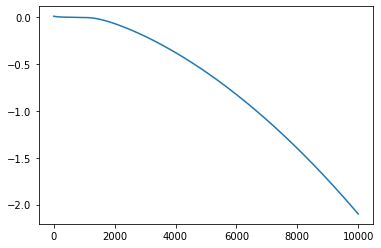

In [79]:
plt.plot(loss_)
plt.show()